<a href="https://colab.research.google.com/github/Pr4navs9/RAVDESS/blob/main/main/RAVDESSAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub

In [2]:
import kagglehub
path = kagglehub.dataset_download("orvile/ravdess-dataset")
print("Path to dataset files:", path)

100%|██████████| 23.9G/23.9G [10:11<00:00, 41.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/orvile/ravdess-dataset/versions/1


In [9]:
import librosa
import librosa.display
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

SAMPLE_RATE = 22050 # Sampling rate
DURATION = 3 # Duration
N_MELS = 128 # Number of Mel bands
MAX_FRAMES = 130 # Fixed time dimension for padding
# Emotion label mapping
EMOTION_MAP = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful",
    "07": "Disgust",
    "08": "Surprised"
}

# AUDIO PREPROCESSING FUNCTIONS
def trim_silence(audio):
    # Removes silent portions from the beginning and end of the audio signal
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)
    return trimmed_audio
def add_noise(audio):
    # Adds low-amplitude Gaussian noise for data augmentation
    noise = np.random.randn(len(audio))
    return audio + 0.005 * noise
def pitch_shift(audio, sr):
    # Randomly shifts pitch up or down
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.uniform(-2, 2))
def time_stretch(audio):
    # Randomly stretches or compresses audio in time
    return librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
def extract_log_mel(audio, sr):
    # Converts audio waveform into Log-Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    # Pads or truncates spectrogram to ensure uniform shape
    if log_mel.shape[1] < MAX_FRAMES:
        pad_width = MAX_FRAMES - log_mel.shape[1]
        log_mel = np.pad(log_mel, pad_width=((0,0),(0,pad_width)))
    else:
        log_mel = log_mel[:, :MAX_FRAMES]
    return log_mel

X = []
y = []
gender_labels = []

dataset_path = path

for file in glob.glob(os.path.join(dataset_path, "**/*.wav"), recursive=True):
    filename = os.path.basename(file)
    # Loading audio file
    audio, sr = librosa.load(file, sr=SAMPLE_RATE, duration=DURATION)
    # Triming silence
    audio = trim_silence(audio)
    # Extracting base features
    mel = extract_log_mel(audio, sr)
    X.append(mel)
    # Extracting emotion label from filename
    emotion_code = filename.split("-")[2]
    y.append(int(emotion_code) -1)
    # Extracting gender (odd actor ID = male, even = female)
    actor_id = int(filename.split("-")[-1].split(".")[0])
    gender_labels.append("Male" if actor_id % 2 else "Female")
    # Data augmentation applied only once per sample
    augmented_audio = add_noise(audio)
    mel_aug = extract_log_mel(augmented_audio, sr)
    X.append(mel_aug)
    y.append(int(emotion_code) - 1)
    gender_labels.append("Male" if actor_id % 2 else "Female")

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Add channel dimension for CNN
X = X[..., np.newaxis]

# One-hot encode labels
y_cat = to_categorical(y, num_classes=8)

In [10]:
print("Total samples:", len(X))
print("Total labels:", len(y))


Total samples: 4904
Total labels: 4904


In [11]:
#TRAIN VALIDATION TEST SPLIT


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42
)

In [12]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(8, activation='softmax'))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32
)
est_loss, test_acc = model.evaluate(X_test, y_test)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

macro_f1 = f1_score(y_true, y_pred, average='macro')

print("Test Accuracy:", test_acc)
print("Macro F1 Score:", macro_f1)

Epoch 1/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.1870 - loss: 2.0339 - val_accuracy: 0.1592 - val_loss: 2.1047
Epoch 2/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2622 - loss: 1.9155 - val_accuracy: 0.1878 - val_loss: 2.0623
Epoch 3/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3050 - loss: 1.8456 - val_accuracy: 0.2469 - val_loss: 1.9822
Epoch 4/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3136 - loss: 1.7899 - val_accuracy: 0.2490 - val_loss: 2.1151
Epoch 5/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3338 - loss: 1.7381 - val_accuracy: 0.3204 - val_loss: 1.9636
Epoch 6/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3586 - loss: 1.6872 - val_accuracy: 0.3082 - val_loss: 1.8825
Epoch 7/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3689 - loss: 1.6357 - val_accuracy: 0.3327 - val_loss: 1.8008
Epoch 8/500
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3904 - loss: 1.6237 -

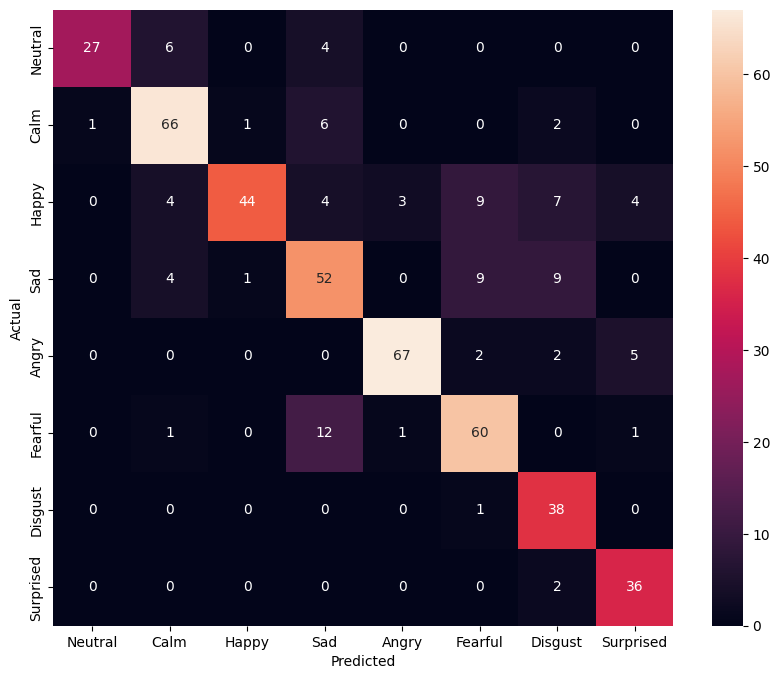

In [14]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=EMOTION_MAP.values(), yticklabels=EMOTION_MAP.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
#GENDER BIAS ANALYSIS
male_idx = [i for i, g in enumerate(gender_labels[:len(y_true)]) if g == "Male"]
female_idx = [i for i, g in enumerate(gender_labels[:len(y_true)]) if g == "Female"]

male_f1 = f1_score(y_true[male_idx], y_pred[male_idx], average='macro')
female_f1 = f1_score(y_true[female_idx], y_pred[female_idx], average='macro')

print("Male Speaker Macro F1:", male_f1)
print("Female Speaker Macro F1:", female_f1)

Male Speaker Macro F1: 0.8146443833943834
Female Speaker Macro F1: 0.7930525806585128


In [16]:

model.save("ser_cnn_model.h5")

In [17]:

def predict_emotion(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    audio = trim_silence(audio)
    mel = extract_log_mel(audio, sr)
   # plt.figure(figsize=(6,4))
   # librosa.display.specshow(
   #   mel,
   #   sr=sr,
   #  x_axis='time',
   #  y_axis='mel'
   #)
   #plt.colorbar(format='%+2.0f dB')
   # plt.title("Log-Mel Spectrogram")
    #plt.show()
    mel = mel[np.newaxis, ..., np.newaxis]
    prediction = model.predict(mel)[0]
    emotion = EMOTION_MAP[str(np.argmax(prediction)+1).zfill(2)]
    confidence = np.max(prediction) * 100
    print(f"Predicted Emotion: {emotion} ({confidence:.2f}%)")

In [18]:
from google.colab import files
files.download("ser_cnn_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>